# Проект урока 5. «Анализ данных о транзакциях»

# Часть 1

В файле `5_lesson_data.zip` имеются следующие данные о транзакциях:

- InvoiceNo — номер заказа  
- StockCode — код товара  
- Description — описание товара  
- Quantity — количество единиц товара, добавленных в заказ  
- InvoiceDate — дата транзакции   
- UnitPrice — цена за единицу товара  
- CustomerID — id клиента  
- Country — страна, где проживает клиент

Каждая строка — это отдельная транзакция (т.е. добавление одного товара в корзину или его удаление, если это запись об отмененной транзакции). В данных нет кода для каждой транзакции, только для товара и для заказа. В одном заказе может быть несколько транзакций. Разные товары могут быть в разных заказах. Неотмененные транзакции считаются реализованными (т.е. эти товары были куплены).

## Шаг 1

Прочитаем данные. **Проверим, встречаются ли в данных повторяющиеся наблюдения.** Если они есть, то удалим их, так как дубликаты негативно влияют на точность анализа данных

In [2]:
import pandas as pd

In [3]:
retail = pd.read_csv('5_lesson_data.zip', encoding='ISO-8859-1', compression='zip')

In [4]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
retail.shape

(541909, 8)

In [6]:
retail.loc[retail.duplicated()].shape

(5268, 8)

In [7]:
retail = retail.drop_duplicates()

In [8]:
retail.shape

(536641, 8)

Продолжим предобработку данных перед их анализом. Данные содержат в себе записи как об успешных транзакциях, так и об отмененных. Если пользователь отменил транзакцию, в начале номера заказа ставится `C` (от `canceled`). **Определим, сколько всего транзакций отменили пользователи**. Удалим эти записи из датафрейма 

In [9]:
retail.InvoiceNo.str.startswith('C').sum()

9251

In [10]:
retail = retail.loc[~retail.InvoiceNo.str.startswith('C')]

## Шаг 2

Наша задача — проанализировать покупки наиболее активных пользователей одной из стран. **Для этого сначала найдем пользователей из Германии, которые совершили значительное количество заказов, т.е. выше определенного порога N**. Наши дан порог — 80-й процентиль. Нужно посчитать число заказов для каждого пользователя из Германии и оставить только тех, кто совершил более N заказов, где N – 80-й процентиль. 

In [11]:
invoice_dist = retail.query('Country == "Germany"')\
                .groupby('CustomerID', as_index=False)\
                .agg({'InvoiceNo':'nunique'})\
                .rename(columns={'InvoiceNo':'total_invoices'})

In [12]:
invoice_dist.head()

,CustomerID,total_invoices
0,12426.0,1
1,12427.0,3
2,12468.0,2
3,12471.0,30
4,12472.0,7


In [13]:
# найдем порог количества заказов 
N = invoice_dist.total_invoices.quantile(q=0.8)

In [14]:
N

7.0

In [19]:
germany_top = invoice_dist.loc[invoice_dist.total_invoices > N]['CustomerID']

In [20]:
germany_top

3     12471.0
6     12474.0
8     12476.0
12    12481.0
16    12500.0
26    12524.0
37    12569.0
44    12600.0
51    12619.0
52    12621.0
56    12626.0
64    12647.0
69    12662.0
77    12705.0
78    12708.0
79    12709.0
81    12712.0
83    12720.0
Name: CustomerID, dtype: float64

Теперь, когда у нас есть нужные id пользователей, мы можете отобрать все записи о транзакциях этих пользователей, чтобы потом их проанализировать. **Возьмем из датафрейма записи только по интересующим нас пользователям из переменной.**

In [21]:
top_retail_germany = retail.loc[retail.CustomerID.isin(germany_top)]

In [22]:
top_retail_germany.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1109,536527,22809,SET OF 6 T-LIGHTS SANTA,6,12/1/2010 13:04,2.95,12662.0,Germany
1110,536527,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,6,12/1/2010 13:04,2.55,12662.0,Germany
1111,536527,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,12,12/1/2010 13:04,0.85,12662.0,Germany
1112,536527,22242,5 HOOK HANGER MAGIC TOADSTOOL,12,12/1/2010 13:04,1.65,12662.0,Germany
1113,536527,22244,3 HOOK HANGER MAGIC GARDEN,12,12/1/2010 13:04,1.95,12662.0,Germany


## Шаг 3

Переходим к анализу данных. **Определим, какой товар отобранные нами активные пользователи из Германии добавляли в корзину чаще всего (без учета количества товара).** Не берем в расчет услугу доставки, обозначенную как `POST`.

In [23]:
top_retail_germany.StockCode.value_counts()

POST     213
22326     52
22328     38
22423     34
20719     30
        ... 
22647      1
21925      1
22111      1
23229      1
22563      1
Name: StockCode, Length: 1158, dtype: int64

**Найдем 5 наиболее крупных по выручке заказов.** 

In [24]:
# создадим колонку с выручкой 
retail = retail.assign(Revenue = retail.UnitPrice * retail.Quantity)

In [25]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [26]:
top_revenue = retail.groupby('InvoiceNo', as_index=False)\
    .agg({'Revenue':'sum'})\
    .rename(columns={'Revenue':'TotalRevenue'})\
    .sort_values('TotalRevenue', ascending=False)\
    .head()

In [27]:
top_revenue

,InvoiceNo,TotalRevenue
22025,581483,168469.60
2303,541431,77183.60
18776,574941,52940.94
19468,576365,50653.91
9741,556444,38970.00


# Часть 2

**Переключаемся на работу с новым датасетом `transaction_data.csv`. Описание данных:**

- date – дата (2020-03-02 00:00:00 – 2020-03-02 01:29:05)  
- name – имя пользователя  
- transaction – статус транзакции  
- minute – сколько минут прошло с начала дня (эта колонка будет доступна в данных с определенного шага)

Каждая строка — это отдельная транзакция.

## Шаг 4

Начнем работу со знакомства с набором данных, проверим их полноту и получим общее представление о структуре данных. Загрузим датасет `5_lesson_transaction_data.csv` и посмотрим на его содержимое. 

In [28]:
data = pd.read_csv('5_lesson_transaction_data.csv')

In [29]:
data.head()

,date,name,transaction
0,2020-03-02 00:37:20,Ekaterina_Petrova,cancelled
1,2020-03-02 00:59:09,Irina_Fedorova,successfull
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull
3,2020-03-02 00:02:58,Lolita_Polyanova,cancelled
4,2020-03-02 00:17:52,Julia_Smirnova,cancelled


In [30]:
data.shape

(5315, 3)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5315 entries, 0 to 5314
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         5315 non-null   object
 1   name         5315 non-null   object
 2   transaction  5315 non-null   object
dtypes: object(3)
memory usage: 124.7+ KB


In [32]:
data.isna().sum()

date           0
name           0
transaction    0
dtype: int64

## Шаг 5

Проанализируем транзакции пользователей с точки зрения статуса транзакций. **Для начала определим количество транзакций того или иного статуса и визуально представим эту информацию с помощью графика барплот.** 

In [33]:
trans_vc = data.transaction.value_counts()

In [34]:
trans_vc

successfull    3692
cancelled      1619
error             4
Name: transaction, dtype: int64

In [35]:
import seaborn as sns

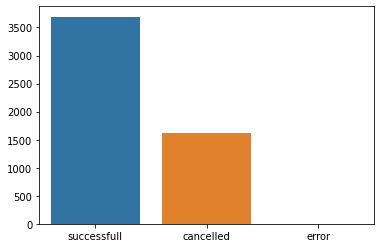

In [36]:
sns.barplot(x=trans_vc.index, y=trans_vc.values)

**А теперь посчитаем, сколько успешных транзакций совершил каждый пользователь.**

In [37]:
success_per_user = data.loc[data.transaction == "successfull"].groupby('name', as_index=False).size()

In [38]:
success_per_user.describe()

,size
count,56.000000
mean,65.928571
std,7.787769
min,46.000000
25%,61.000000
50%,64.000000
75%,72.000000
max,82.000000


- Пользователи в среднем совершили примерно по 66 транзакций  
- Максимальное число транзакций – 82  
- Примерно 25% пользователей совершили менее 61 транзакции  

**На основе расчетов с прошлого шага построим гистограмму.**

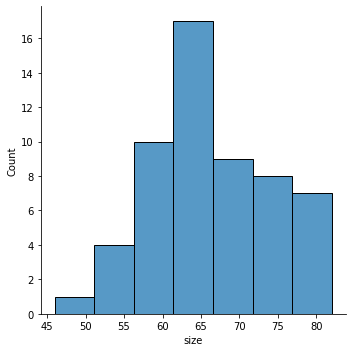

In [39]:
sns.displot(data=success_per_user, x='size')

- Ни один пользователь не совершил 45 транзакций  
- Пользователей, совершивших от 45 до 55 транзакций, меньше, чем пользователей, совершивших от 70 до 80 транзакций    
- Распределение имеет пик по центру и снижающиеся значения по бокам

## Шаг 6

**Пришёл коллега из маркетингового отдела с немного обновленными данными — см.датасет `5_lesson_transaction_data_updated.csv`.** Он попросил сформировать сводную таблицу, которая покажет, какое количество операций осуществлял каждый пользователь в каждую минуту наблюдаемого временного промежутка. Эта информация нужна вашему коллеге для того, чтобы оценить, не было ли аномального скачка в количестве операций — как раз в то время рекламу вашей компании опубликовал известный блогер, ваш коллега хочет отследить, была ли быстрая реакция на неё.

**Построим сводную таблицу `pivot_trans_per_min`,** где:

- столбцы – имена пользователей  
- строки – минута времени осуществления операции (см.колонку `minute`)  
- значения – число совершённых операций

Пропущенные значения заполним нулями.

In [45]:
df = pd.read_csv('5_lesson_transaction_data_updated.csv', parse_dates=['date'])

In [46]:
df.head()

,date,name,transaction,minute
0,2020-03-02 00:37:20,Ekaterina_Petrova,cancelled,37
1,2020-03-02 00:59:09,Irina_Fedorova,successfull,59
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull,6
3,2020-03-02 00:02:58,Lolita_Polyanova,cancelled,2
4,2020-03-02 00:17:52,Julia_Smirnova,cancelled,17


In [47]:
df.shape

(5315, 4)

In [48]:
trans_per_minute = df.groupby(['name', 'minute'], as_index=False).size()

In [49]:
trans_per_minute.head()

,name,minute,size
0,Ekaterina_Fedorova,0,3
1,Ekaterina_Fedorova,1,4
2,Ekaterina_Fedorova,2,1
3,Ekaterina_Fedorova,3,3
4,Ekaterina_Fedorova,4,3


In [50]:
pivot_trans_per_min = trans_per_minute.pivot(index='minute', columns='name', values='size')

In [51]:
pivot_trans_per_min.head()

name,Ekaterina_Fedorova,Ekaterina_Ivanova,Ekaterina_Lesnova,Ekaterina_Ozerova,Ekaterina_Petrova,Ekaterina_Polyanova,Ekaterina_Smirnova,Irina_Fedorova,Irina_Ivanova,Irina_Lesnova,...,Svetlana_Petrova,Svetlana_Polyanova,Svetlana_Smirnova,Vasilisa_Fedorova,Vasilisa_Ivanova,Vasilisa_Lesnova,Vasilisa_Ozerova,Vasilisa_Petrova,Vasilisa_Polyanova,Vasilisa_Smirnova
minute,,,,,,,,,,,,,,,,,,,,,
0,3.0,4.0,2.0,3.0,4.0,4.0,2.0,1.0,2.0,2.0,...,NaN,3.0,1.0,1.0,4.0,1.0,3.0,NaN,NaN,1.0
1,4.0,4.0,NaN,4.0,2.0,5.0,4.0,4.0,4.0,3.0,...,4.0,5.0,3.0,2.0,3.0,3.0,NaN,NaN,3.0,2.0
2,1.0,2.0,4.0,4.0,2.0,1.0,3.0,2.0,3.0,3.0,...,4.0,1.0,3.0,3.0,NaN,1.0,2.0,1.0,3.0,1.0
3,3.0,NaN,2.0,NaN,5.0,2.0,1.0,3.0,2.0,2.0,...,1.0,5.0,5.0,2.0,4.0,NaN,3.0,4.0,1.0,NaN
4,3.0,NaN,NaN,3.0,1.0,1.0,2.0,3.0,2.0,1.0,...,1.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,NaN,1.0


In [52]:
pivot_trans_per_min = pivot_trans_per_min.fillna(0)

In [53]:
pivot_trans_per_min.head()

name,Ekaterina_Fedorova,Ekaterina_Ivanova,Ekaterina_Lesnova,Ekaterina_Ozerova,Ekaterina_Petrova,Ekaterina_Polyanova,Ekaterina_Smirnova,Irina_Fedorova,Irina_Ivanova,Irina_Lesnova,...,Svetlana_Petrova,Svetlana_Polyanova,Svetlana_Smirnova,Vasilisa_Fedorova,Vasilisa_Ivanova,Vasilisa_Lesnova,Vasilisa_Ozerova,Vasilisa_Petrova,Vasilisa_Polyanova,Vasilisa_Smirnova
minute,,,,,,,,,,,,,,,,,,,,,
0,3.0,4.0,2.0,3.0,4.0,4.0,2.0,1.0,2.0,2.0,...,0.0,3.0,1.0,1.0,4.0,1.0,3.0,0.0,0.0,1.0
1,4.0,4.0,0.0,4.0,2.0,5.0,4.0,4.0,4.0,3.0,...,4.0,5.0,3.0,2.0,3.0,3.0,0.0,0.0,3.0,2.0
2,1.0,2.0,4.0,4.0,2.0,1.0,3.0,2.0,3.0,3.0,...,4.0,1.0,3.0,3.0,0.0,1.0,2.0,1.0,3.0,1.0
3,3.0,0.0,2.0,0.0,5.0,2.0,1.0,3.0,2.0,2.0,...,1.0,5.0,5.0,2.0,4.0,0.0,3.0,4.0,1.0,0.0
4,3.0,0.0,0.0,3.0,1.0,1.0,2.0,3.0,2.0,1.0,...,1.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,0.0,1.0


Получив сводную таблицу, наш коллега построил по ней график, где по оси `x` – минута транзакции (сколько минут прошло с начала дня), а по оси `y` – число транзакций. Но коллега сомневается, что в данных нет ошибки

![](https://ucarecdn.com/76242146-2d40-40d8-9a4d-2069d97da56f/-/crop/746x502/52,40/-/preview/)

**Определим, из-за чего мы видим такую картину. Произошла ошибка или с данными всё хорошо?**

In [54]:
minute_trans = pivot_trans_per_min.sum(axis=1)

In [55]:
minute_trans.head()

minute
0    111.0
1    145.0
2    123.0
3    129.0
4     92.0
dtype: float64

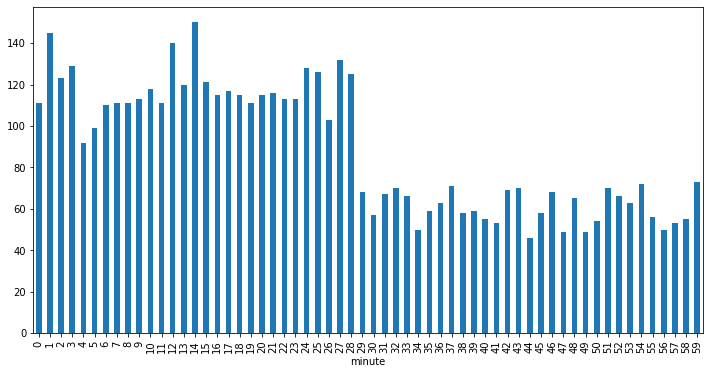

In [56]:
minute_trans.plot.bar(figsize=(12,6))

In [57]:
df.date.describe(datetime_is_numeric=True)

count                             5315
mean     2020-03-02 00:43:56.628974592
min                2020-03-02 00:00:00
25%         2020-03-02 00:21:50.500000
50%                2020-03-02 00:43:26
75%         2020-03-02 01:06:22.500000
max                2020-03-02 01:29:05
Name: date, dtype: object

**Ошибка = извлекли минутную часть времени, а не число минут с начала дня**

## Шаг 7

**Исправим ошибку и подсчитаем правильное количество минут, прошедших с начала дня.**

In [58]:
df['true_minute'] = df.date.dt.minute + df.date.dt.hour * 60

In [59]:
df.head()

,date,name,transaction,minute,true_minute
0,2020-03-02 00:37:20,Ekaterina_Petrova,cancelled,37,37
1,2020-03-02 00:59:09,Irina_Fedorova,successfull,59,59
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull,6,66
3,2020-03-02 00:02:58,Lolita_Polyanova,cancelled,2,2
4,2020-03-02 00:17:52,Julia_Smirnova,cancelled,17,17


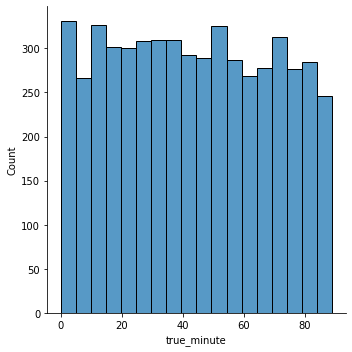

In [60]:
sns.displot(data=df, x='true_minute')